In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
# import sklearn
# sklearn.__version__
# # '1.0.2'

In [3]:
# Custom rc definitions
rc = {
        'axes.spines.right': True,
        'axes.spines.top': True,
        'font.family': ['sans-serif'],
        'font.sans-serif':
        # 'Arial',
        'DejaVu Sans',
        # 'Liberation Sans',
        # 'Bitstream Vera Sans',
        # 'sans-serif',
        "xtick.bottom":True,
        'axes.edgecolor': 'indigo',
        'xtick.color': 'black',
        'figure.facecolor': "snow",
        'grid.color': 'grey',
        
}


# font definitions
font_label = {'family': 'serif',
        'color':  'darkred',
        'weight': 'semibold',
        'size': 16,
        }

font_title = {'family': 'serif',
        'color':  'black',
        'weight': 'semibold',
        'size': 16,
        }

font_fig = {'family': 'sans',
        'color':  'chocolate',
        # 'weight': 'bold', # doesn't apply to it. Must be specified independently
        # 'fontsize': 30, # doesn't apply to it. Must be specified independently
        }

In [4]:
data = pd.read_csv("../my_data/clusters.csv")

In [5]:
data.head()

,area,majoraxislength,minoraxislength,eccentricity,convexarea,equivdiameter,extent,perimeter,roundness,aspectration,class,clusters
0,6374,129.577,63.762,0.871,6476,90.087,0.662,314.656,0.809,2.032,jasmine,3
1,6946,136.304,65.738,0.876,7115,94.042,0.594,338.782,0.761,2.073,jasmine,1
2,5786,125.555,59.626,0.880,5945,85.831,0.623,307.304,0.770,2.106,jasmine,3
3,5896,127.014,59.843,0.882,6092,86.643,0.610,309.264,0.775,2.122,jasmine,3
4,6082,129.098,60.416,0.884,6204,87.999,0.661,308.106,0.805,2.137,jasmine,3


In [6]:
data = pd.get_dummies(data,columns=['class'],drop_first=True)
data.head()

,area,majoraxislength,minoraxislength,eccentricity,convexarea,equivdiameter,extent,perimeter,roundness,aspectration,clusters,class_jasmine
0,6374,129.577,63.762,0.871,6476,90.087,0.662,314.656,0.809,2.032,3,1
1,6946,136.304,65.738,0.876,7115,94.042,0.594,338.782,0.761,2.073,1,1
2,5786,125.555,59.626,0.880,5945,85.831,0.623,307.304,0.770,2.106,3,1
3,5896,127.014,59.843,0.882,6092,86.643,0.610,309.264,0.775,2.122,3,1
4,6082,129.098,60.416,0.884,6204,87.999,0.661,308.106,0.805,2.137,3,1


In [26]:
from sklearn.model_selection import \
    GridSearchCV,ShuffleSplit,train_test_split

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import  Pipeline
from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler

from sklearn.decomposition import PCA
from sklearn.linear_model import SGDRegressor,LinearRegression

from sklearn.ensemble import \
    RandomForestRegressor,GradientBoostingRegressor

In [8]:
X = data.drop(columns=["extent"])
y = data.extent

In [9]:
to_transform = ['area','majoraxislength','minoraxislength',
                'convexarea','equivdiameter','perimeter']

indexes = [ X.columns.tolist().index(value) for value in to_transform]
indexes

[0, 1, 2, 4, 5, 6]

In [10]:
# Scaler
scaler = StandardScaler()

# Column transformer
ct1 = ColumnTransformer([
    ('scale',scaler,indexes)],
    remainder='passthrough')

In [11]:
ct1

ColumnTransformer(remainder='passthrough',
                  transformers=[('scale', StandardScaler(),
                                 [0, 1, 2, 4, 5, 6])])

In [36]:
my_pipe = Pipeline([
    ("ct",ct1),
    # ('pca',PCA(n_components=6)),
    ('reg',LinearRegression(n_jobs=-2))
])

In [37]:
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42,test_size=.20)

In [38]:
my_params = [
    { # Column Transformer
        "ct__scale":[RobustScaler(),MinMaxScaler()]
    },
    
    {
        # RandomForestRegressor
        'reg':[RandomForestRegressor(random_state=42,warm_start=True,n_jobs=-2)],
        "reg__n_estimators":[50,100],
        "reg__max_depth":[3,5],
        'reg__min_samples_split':[2,3]
    },

    {
        # SGDRegressor
        "reg":[SGDRegressor(random_state=42,warm_start=True,max_iter=100)],
        'reg__early_stopping':[True,False],
        "reg__alpha":[0.0001,0.001,0.01]
    },

    {
        # GradientBoostingRegressor
        "reg":[GradientBoostingRegressor(random_state=42,warm_start=True)],
        "reg__learning_rate":[0.001,0.01,0.1,1],
        "reg__n_estimators":[50,100],
        "reg__min_samples_split":[2,3],
        "reg__max_depth":[3,5]
    }
]

my_cv = ShuffleSplit(n_splits=5,test_size=.20,random_state=42)

In [39]:
# mygrid = GridSearchCV(my_pipe,param_grid=my_params,
#         cv=my_cv,scoring="neg_root_mean_squared_error")

mygrid = GridSearchCV(my_pipe,param_grid=my_params,cv=my_cv)
mygrid.fit(X_train,y_train)

GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=42, test_size=0.2, train_size=None),
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('scale',
                                                                         StandardScaler(),
                                                                         [0, 1,
                                                                          2, 4,
                                                                          5,
                                                                          6])])),
                                       ('reg', LinearRegression(n_jobs=-2))]),
             param_grid=[{'ct__scale': [RobustScaler(), MinMaxScaler()]},
                         {'reg': [RandomForestRegressor(n_job...
                          'reg__n_estimators': [50, 100]},
           

In [41]:
print(f"Best params: {mygrid.best_params_}\n")
print(f"Best estimator: {mygrid.best_estimator_}\n")
print(f"Best validation score: {mygrid.best_score_}")

Best params: {'ct__scale': RobustScaler()}

Best estimator: Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scale', RobustScaler(),
                                                  [0, 1, 2, 4, 5, 6])])),
                ('reg', LinearRegression(n_jobs=-2))])

Best validation score: 0.13624866157730717


In [42]:
print(mygrid.best_estimator_.named_steps['reg'].coef_,"\n") # Coefficients
print(mygrid.best_estimator_.named_steps["reg"].n_features_in_,"\n") # Number of feaetures present
print(mygrid.best_estimator_.named_steps["reg"].intercept_,"\n") # intercept

[-1.62715682e-01 -6.19849191e-02 -1.22989275e-01  1.42760108e-01
  7.16604585e-02  8.35386084e-02  9.40447225e-02  1.18770469e+00
  5.24170566e-02  9.97371683e-04  9.63695218e-03] 

11 

-0.4386527418604237 



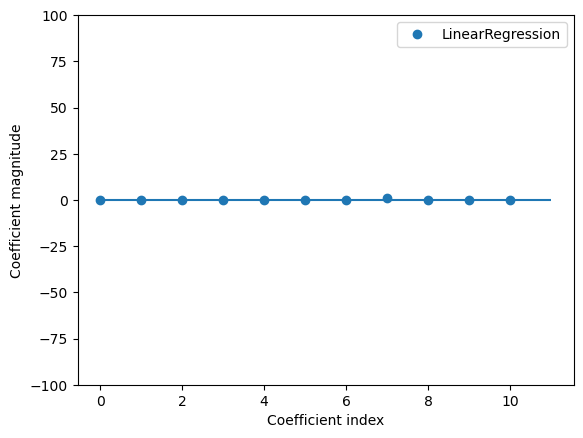

In [43]:
plt.plot(mygrid.best_estimator_.named_steps["reg"].coef_, 'o', label="LinearRegression")
plt.xlabel("Coefficient index")
plt.ylabel("Coefficient magnitude")
plt.hlines(0, 0, len(mygrid.best_estimator_.named_steps["reg"].coef_))
plt.ylim(-100, 100)
plt.legend()

In [46]:
from sklearn.metrics import  mean_squared_error
y_pred_test = mygrid.predict(X_test) # prediction
print(f'RMSE test: {np.around((mean_squared_error(y_test, y_pred_test,squared=False)))}') # RMSE scoe
print(f"Accuracy score (r^2): {np.around(mygrid.score(X_test, y_test),3)}") # r^2 score
print(f'Standard Deviation of Extent: {np.around(data.extent.std(),3)}') # std of Extent
# RMSE score is lower than std of Extent; Algorithm does well?

RMSE test: 0.0
Accuracy score (r^2): 0.132
Standard Deviation of Price: 0.104


In [47]:
percent_error = 100* ((y_pred_test-y_test)/y_test)
data = {
    'predicted_extent':y_pred_test,
    'actual_extent':y_test,
    "percentage_error":percent_error
}
predictions_frame = pd.DataFrame(data)
predictions_frame.to_csv("../my_data/reg_predictions/main_regression.csv"
                    ,index=True)
predictions_frame.head(5)

,predicted_extent,actual_extent,percentage_error
5277,0.586066,0.651,-9.974558
8354,0.578613,0.469,23.371735
2718,0.590143,0.547,7.887214
7895,0.563772,0.479,17.697739
4205,0.591294,0.667,-11.350168


In [59]:
cond = (predictions_frame.percentage_error == 0)
predictions_frame.loc[cond,:].value_counts().sum()

0

Text(0, 0.5, 'Actual Extent')

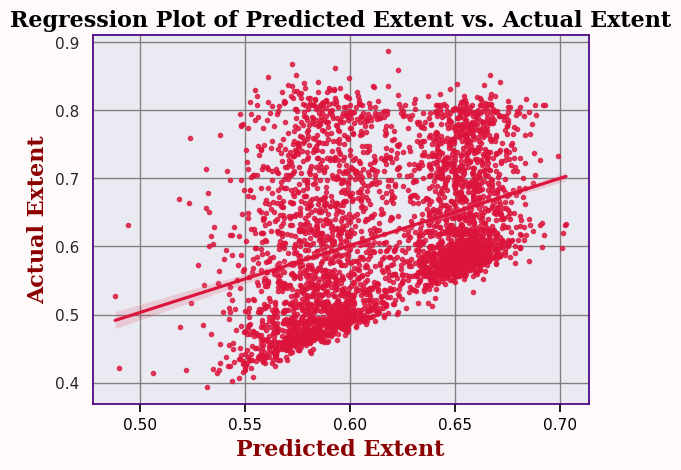

In [58]:
# Regression plot
sns.set_theme(style='darkgrid',rc=rc)
sns.regplot(data=predictions_frame,
        x='predicted_extent',
        y='actual_extent',
        fit_reg=True,
        color='crimson',
        marker='.')
plt.title('Regression Plot of Predicted Extent vs. Actual Extent',fontdict=font_title)
plt.xlabel('Predicted Extent',fontdict=font_label)
plt.ylabel('Actual Extent',fontdict=font_label)

In [55]:
import random

def generate_new_data():
    new_data_points = []
    
    for _ in range(5):
        new_data_point = []
        
        # Generate random values for the features
        new_data_point.append(random.randint(0, 10000)) # area
        new_data_point.append(random.uniform(0, 200))   # majoraxislength
        new_data_point.append(random.uniform(0, 100))   # minoraxislength
        new_data_point.append(random.uniform(0, 1))     # eccentricity    
        new_data_point.append(random.randint(0, 10000)) # convexarea
        new_data_point.append(random.uniform(0, 200))   # equivdiameter
        new_data_point.append(random.uniform(0, 500))   # perimeter
        new_data_point.append(random.uniform(0, 1))     # roundness
        new_data_point.append(random.uniform(0, 5))     # aspectration
        new_data_point.append(random.randint(0, 1))     # class
        new_data_point.append(random.randint(0, 4))     # clusters

        
        new_data_points.append(new_data_point)
    
    return new_data_points

# Generate 5 new data points
new_data = generate_new_data()
# The list
print(len(new_data),"\n")
print(new_data,"\n")

# The inner list
print(new_data[0],"\n")
print(len(new_data[0]),"\n")

5 

[[2434, 8.380338991788893, 73.75121443250389, 0.27181793908335217, 8414, 85.08154872777195, 369.5798298671175, 0.29193851748098787, 3.332859793197221, 0, 3], [6545, 80.69592757860191, 5.5264206289855515, 0.6488761089836178, 1812, 178.69217249110548, 223.06396551021584, 0.381816994601646, 1.893362350446166, 1, 1], [4910, 75.06133731031997, 77.78646555683282, 0.3749753019845321, 5350, 130.6426841099809, 242.04148810101262, 0.4280546982434015, 4.585664133453308, 1, 3], [3615, 110.12585463711007, 54.822502242197736, 0.44244899554658335, 8005, 63.095760871464826, 104.32214221991536, 0.23282534690826595, 4.119081914454875, 1, 3], [7797, 90.70698970324258, 92.73285862806449, 0.9296958157359845, 4677, 12.322019782351212, 259.1726718313034, 0.1965427440278391, 2.1442730971199513, 1, 2]] 

[2434, 8.380338991788893, 73.75121443250389, 0.27181793908335217, 8414, 85.08154872777195, 369.5798298671175, 0.29193851748098787, 3.332859793197221, 0, 3] 

11 



In [56]:
mygrid.predict(new_data)

array([ 1.05170845,  0.66140126,  0.54178968, -0.07964336, -0.70515269])

In [57]:
import pickle

with open('../model/main_regression.pkl','wb') as f:
    pickle.dump(mygrid.best_estimator_,f)